# Predict Sales

In [24]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

import pickle
import warnings
#import scikitplot as skplt

In [2]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

### Load Data

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [5]:
dataset_train, dataset_test = load_train_test()

In [6]:
dataset_train.isna().sum()

customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              222825
mcp_contact_id             70874
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                224213
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date           66139
max_price                  66139
ticket_sum                     0
average_price              66023
average_purchase_delay     66139
average_price_basket       66139
average_ticket_basket      66139
total_price                  116
purchase_count                 0
first_buying_date          66139
country   

In [7]:
def features_target_split(dataset_train, dataset_test):
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)

In [9]:
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (224213, 17)
Shape test :  (96096, 17)


### Prepare preprocessing and Hyperparameters

In [10]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5837086520288036, 1.0: 3.486549107420539}

In [11]:
numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']

numeric_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="mean")),  
    ("scaler", StandardScaler()) 
])

categorical_features = ['opt_in']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [12]:
# Set loss
balanced_scorer = make_scorer(balanced_accuracy_score)
recall_scorer = make_scorer(recall_score)

In [26]:
def draw_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def draw_roc_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    
    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (14, 8))
    plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve", size=18)
    plt.legend(loc="lower right")
    plt.show()


def draw_calibration_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test,  y_pred_prob, n_bins=10)

    # Plot the calibration curve
    plt.plot(mean_pred, frac_pos, 's-', label='Logistic Regression')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positive predictions')
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()

In [35]:
def draw_features_importance(pipeline, model, randomF = False):
    if randomF:
        coefficients = pipeline.named_steps[model].feature_importances_
    else: 
        coefficients = pipeline.named_steps[model].coef_[0]
    
    feature_names = pipeline.named_steps[model].feature_names_in_
    
    # Tracer l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel("Features' Importance")
    plt.ylabel('Caractéristiques')
    plt.title("Features' Importance")
    plt.grid(True)
    plt.show()

def draw_prob_distribution(X_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred_prob, bins=10, range=(0, 1), color='blue', alpha=0.7)
    
    plt.xlim(0, 1)
    plt.ylim(0, None)
    
    plt.title('Histogramme des probabilités pour la classe 1')
    plt.xlabel('Probabilité')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()


In [15]:
# Hyperparameter
param_grid = {'logreg__C': np.logspace(-10, 6, 17, base=2),
              'logreg__penalty': ['l1', 'l2'],
               'logreg__class_weight': ['balanced', weight_dict]} 

In [16]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('logreg', LogisticRegression(solver='saga', class_weight = weight_dict,
                                  max_iter=5000, n_jobs=-1))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'time_between_purchase',
                                                   'nb_tickets_internet',
                                                   'is_email_true', 'opt_in',
                                                   'gender_female',
                                                   'gender_male',
                                                   'gender_other',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

## Baseline

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'time_between_purchase',
                                                   'nb_tickets_internet',
                                                   'is_email_true', 'opt_in',
                                                   'gender_female',
                                                   'gender_male',
                                                   'gender_other',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5837086520288036,
                                                  1.0: 3.486549107420539},
                                    max_iter=5000, solver='saga'))])

In [18]:
y_pred = pipeline.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.764547952047952
F1 Score: 0.4741074748977315
Recall Score: 0.7449963476990504


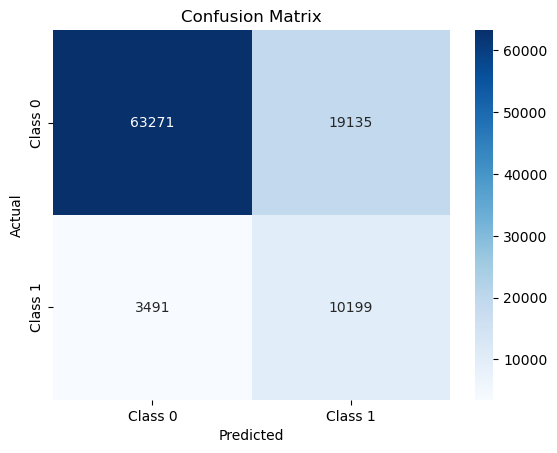

In [19]:
draw_confusion_matrix(y_test, y_pred)

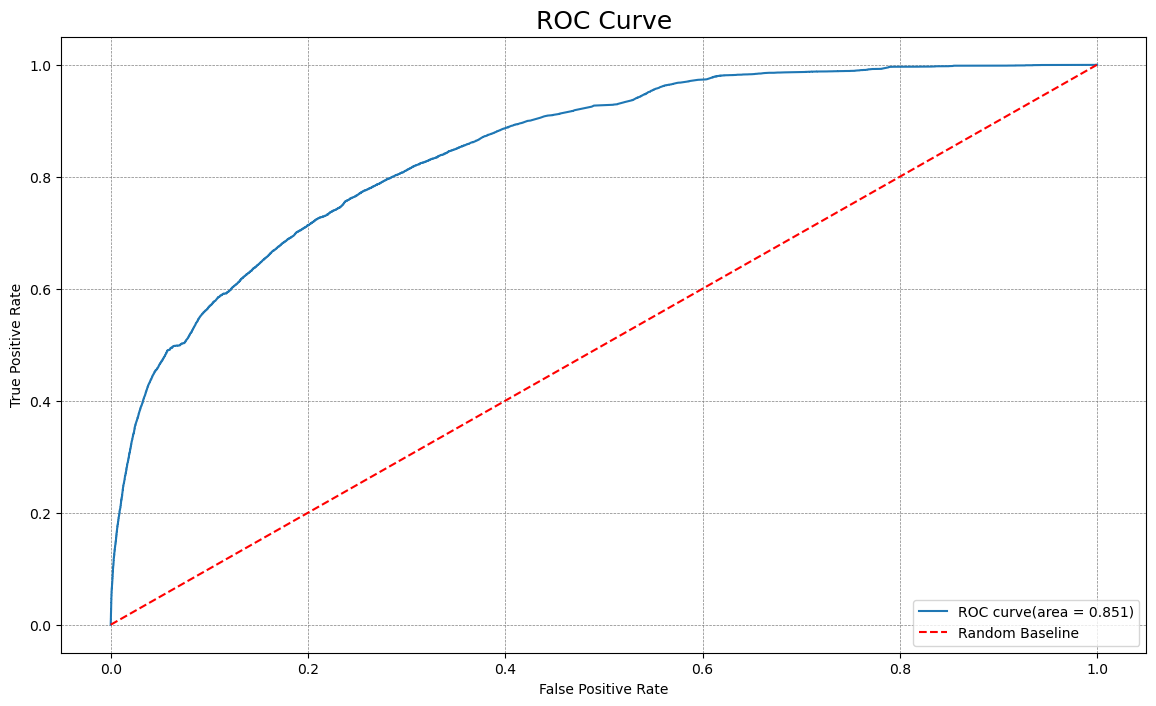

In [20]:
draw_roc_curve(X_test, y_test)

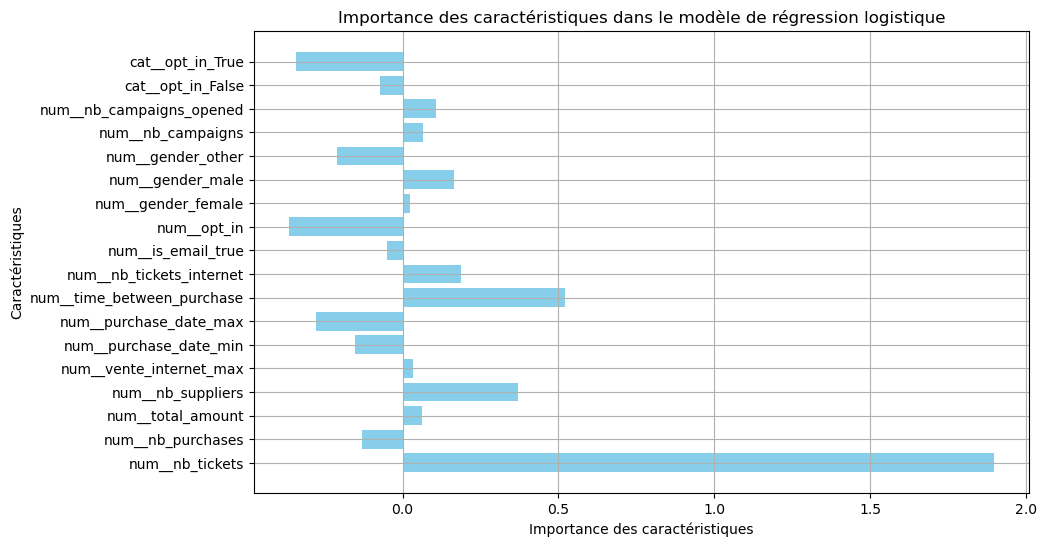

In [21]:
draw_features_importance(pipeline, 'logreg')

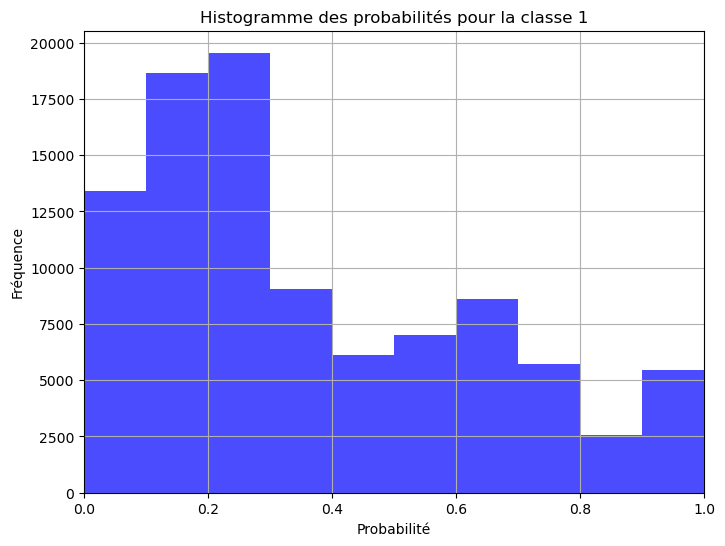

In [22]:
draw_prob_distribution(X_test)

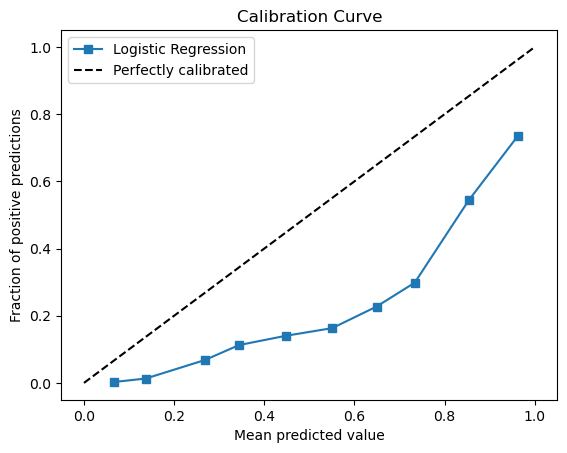

In [27]:
draw_calibration_curve(X_test, y_test)

## Cross Validation

In [40]:
y_train = y_train['y_has_purchased']

In [41]:
# Cross validation

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=recall_scorer, error_score='raise',
                          n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Best parameters found:  {'logreg__C': 0.0009765625, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}
Best cross-validation score: 0.65
Test set score: 0.64


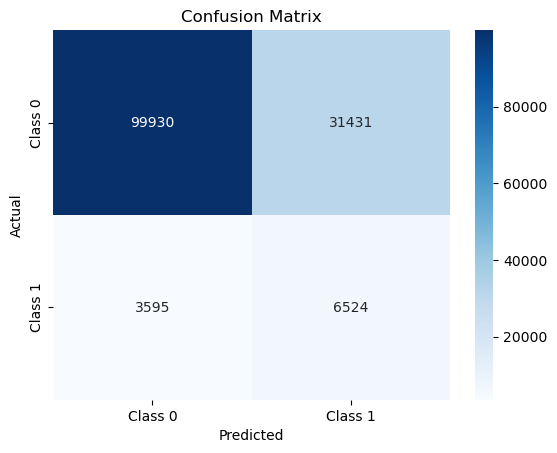

In [43]:
y_pred = grid_search.predict(X_test)

draw_confusion_matrix(y_test, y_pred)

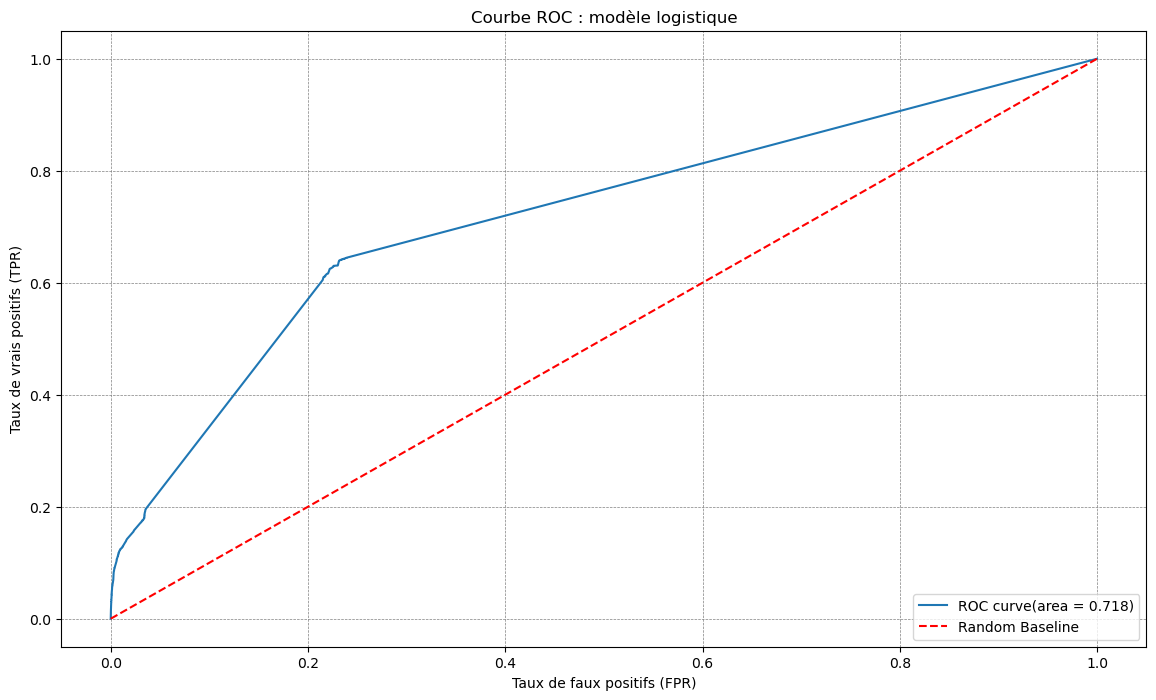

In [44]:
draw_roc_curve(X_test, y_test)

# Segmentation du score de prédiction

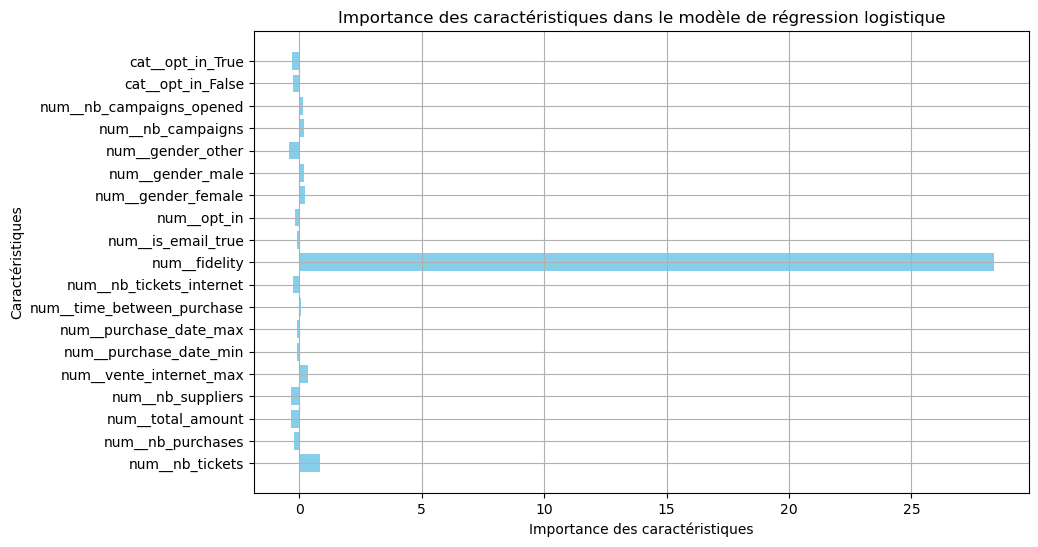

In [61]:
coefficients = pipeline.named_steps['logreg'].coef_[0]
feature_names = pipeline.named_steps['logreg'].feature_names_in_

# Tracer l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.grid(True)
plt.show()

In [70]:
# Création d'un dataframe avec le score
dataset_for_segmentation = dataset_test[['customer_id'] + numeric_features + categorical_features]

y_predict_proba = pipeline.predict_proba(X_test)[:, 1]

dataset_for_segmentation['prediction_probability'] = y_predict_proba

# Arrondir les valeurs de la colonne 'prediction_probability' et les multiplier par 10
dataset_for_segmentation['category'] = dataset_for_segmentation['prediction_probability'].apply(lambda x: int(x * 10))

dataset_for_segmentation['prediction'] = y_pred

def premiere_partie(chaine):
    if chaine:
        return chaine.split('_')[0]
    else:
        return None

dataset_for_segmentation['company_number'] = dataset_for_segmentation['customer_id'].apply(lambda x: premiere_partie(x))

In [73]:
# Grouper le DataFrame par la colonne 'category' et calculer la moyenne pour chaque groupe
summary_stats = dataset_for_segmentation.groupby('category')[numeric_features].describe()

# Sélectionner uniquement la colonne 'mean' pour chaque variable numérique
mean_stats = summary_stats.loc[:, (slice(None), 'mean')]

# Afficher le DataFrame résultant
mean_stats

nb_tickets nb_purchases  total_amount nb_suppliers  \
                 mean         mean          mean         mean   
category                                                        
0            0.113637     0.006274      1.586366     0.005821   
1            0.810841     0.128432      9.611292     0.125295   
2            1.159419     0.339253     15.182143     0.337577   
3            2.153080     0.744161     27.820044     0.734881   
4            2.044749     0.777640     27.353145     0.754549   
5            3.237988     0.958520     46.637380     0.807655   
6            3.592233     1.102881     49.989226     0.878014   
7            3.747016     1.391266     40.710335     0.914702   
8            5.698276     1.567006     63.033699     0.907915   
9           14.505956     3.211571    107.288514     1.011628   
10        2262.859155    45.619718  11051.732394     1.464789   

         vente_internet_max purchase_date_min purchase_date_max  \
                       mean              mean              mean   
category                                                          
0                  0.000647        548.790455        548.773103   
1                  0.018186        525.437516        525.275222   
2                  0.323824        501.529129        501.415505   
3                  0.600982        287.051054        286.675385   
4                  0.079213        297.179255        295.019902   
5                  0.484785        387.464785        380.145068   
6                  0.599906        268.627019        250.949344   
7                  0.160990        309.716173        274.795570   
8                  0.334248        326.485952        257.940194   
9                  0.157119        369.696066        209.280306   
10                 0.154930        467.111875         31.146796   

         time_between_purchase nb_tickets_internet   fidelity gender_female  \
                          mean                mean       mean          mean   
category                                                                      
0                    -0.977118            0.001585   0.000776      0.000000   
1                    -0.729328            0.054312   0.111832      0.245480   
2                    -0.554439            0.969939   0.304757      0.392570   
3                     0.105360            1.776035   0.659878      0.288813   
4                     1.898178            0.293760   0.894877      0.666980   
5                     7.111357            2.080397   1.164958      0.497758   
6                    17.539247            2.525994   1.420921      0.534607   
7                    34.796876            0.844250   1.963028      0.650364   
8                    68.425460            2.794279   2.413009      0.606583   
9                   160.348544            3.514464   5.394498      0.669314   
10                  435.950994           54.295775  64.704225      0.507042   

         gender_male gender_other nb_campaigns nb_campaigns_opened  
                mean         mean         mean                mean  
category                                                            
0           0.000032     0.999968    13.984219            1.302720  
1           0.495929     0.258591    18.413562            3.718711  
2           0.297258     0.310173    17.395042            2.608084  
3           0.253244     0.457943    16.790421            4.173954  
4           0.301424     0.031596    16.954707            6.060621  
5           0.259769     0.242473    27.006406           12.457719  
6           0.304259     0.161134    14.073285            4.604134  
7           0.263464     0.086172    26.186317            8.891703  
8           0.251567     0.141850    30.987461           11.676332  
9           0.223766     0.106920    45.928247           18.241634  
10          0.295775     0.197183    53.352113           26.070423

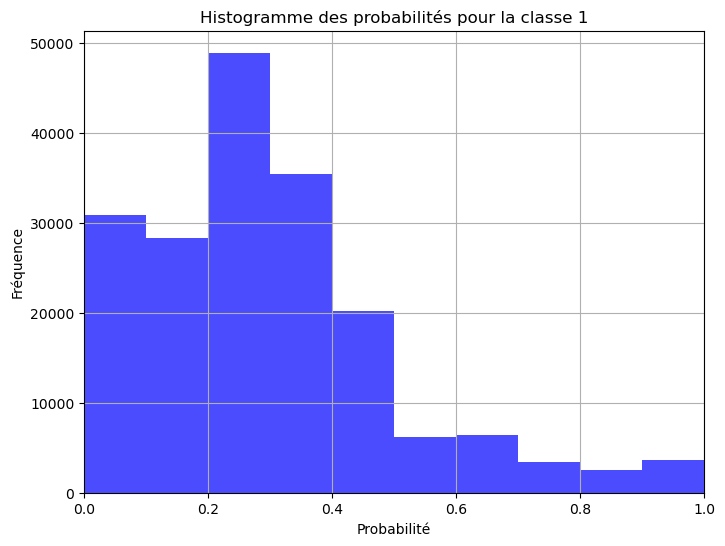

In [75]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(y_predict_proba, bins=10, range=(0, 1), color='blue', alpha=0.7)

# Réglage des limites des axes x et y
plt.xlim(0, 1)
plt.ylim(0, None)  # Laissez le maximum sur l'axe y pour s'ajuster automatiquement

plt.title('Histogramme des probabilités pour la classe 1')
plt.xlabel('Probabilité')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()


### Random Forest

#### Benchmark 

In [28]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preproc),
    ('randomF', RandomForestClassifier(class_weight = weight_dict,
                                  n_jobs=-1))  
])

In [29]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'vente_internet_max',
                                                   'purchase_date_min',
                                                   'purchase_date_max',
                                                   'time_between_purchase',
                                                   'nb_tickets_internet',
                                                   'is_email_true', 'opt_in',
                                                   'gender_female',
                                                   'gender_male',
                                                   'gender_other',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in'])])),
                ('randomF',
                 RandomForestClassifier(class_weight={0.0: 0.5837086520288036,
                                                      1.0: 3.486549107420539},
                                        n_jobs=-1))])

In [30]:
y_pred = pipeline_rf.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.8915667665667666
F1 Score: 0.5773505313539385
Recall Score: 0.5198685171658145


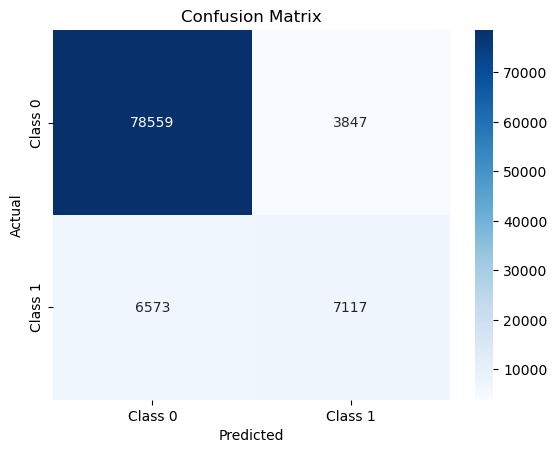

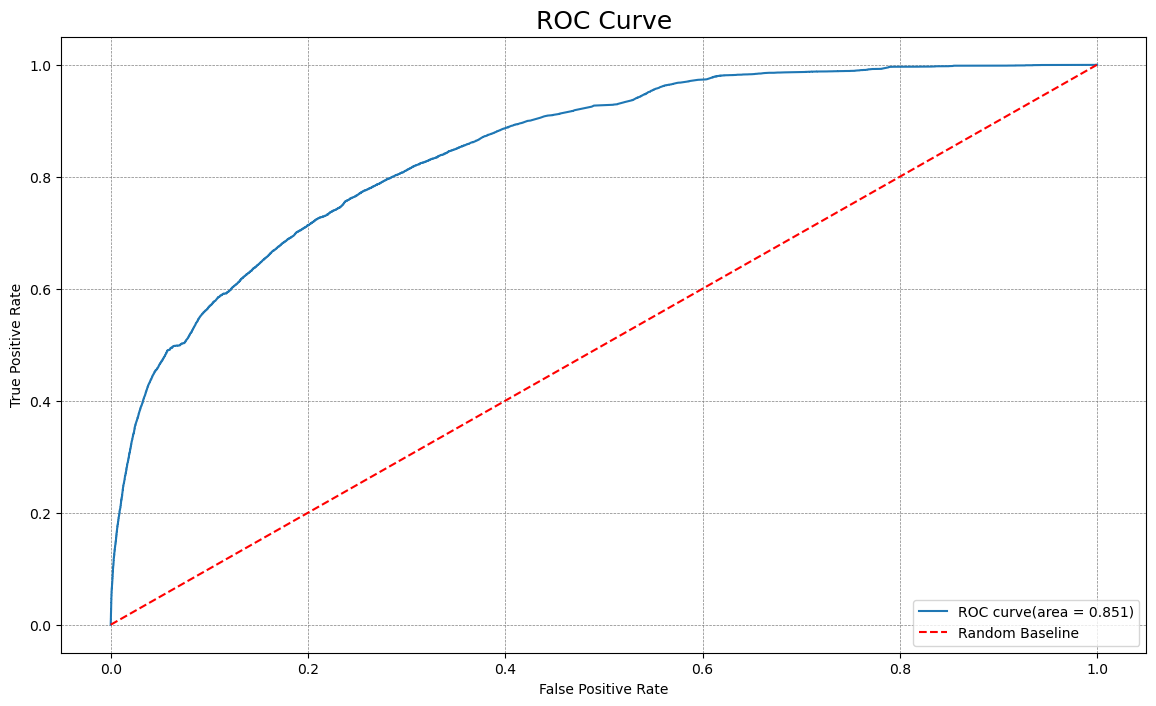

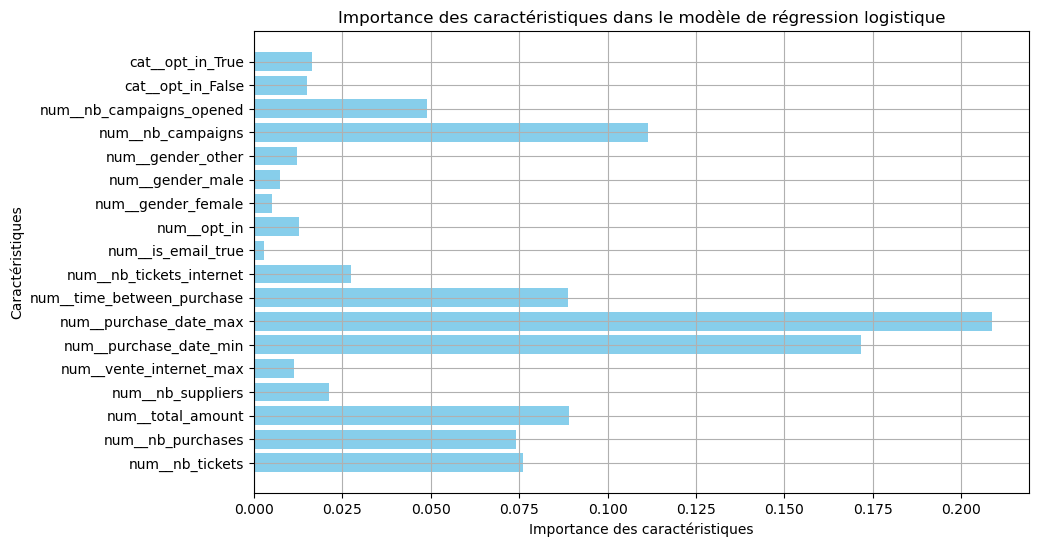

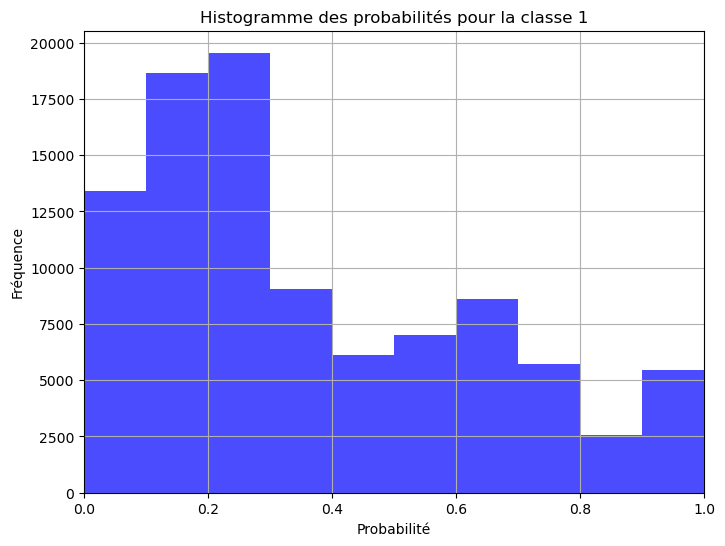

In [36]:
draw_confusion_matrix(y_test, y_pred)
draw_roc_curve(X_test, y_test)
draw_features_importance(pipeline_rf, 'randomF', randomF =True)
draw_prob_distribution(X_test)